In [3]:
# !pip install keras

     ---------------------------------------- 1.7/1.7 MB 1.4 MB/s eta 0:00:00

[notice] A new release of pip available: 22.1.2 -> 22.3.1
[notice] To update, run: C:\Users\merli\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [1]:
import keras
keras.__version__

'2.10.0'

# Advanced applications of recursive neural networks

We will present  three advanced techniques to improve the performance of recursive neural networks and their ability to create generalizations. All three techniques will be presented on the example of predicting temperature. This is done on the basis of a set in the form of a time series of values read from sensors mounted on the roof of the building. These values determine the temperature, pressure and humidity of the air. We will use them to predict the temperature in 24 hours from the last observation. This is quite a difficult task. On the basis of this tak we will be able to draw attention to many difficulties encountered when working with time series data.

We will describe the following techniques:
* Recursive rejection – A built-in rejection algorithm designed to prevent recursive layers from being overshadowed;
* creating stacks of recursive layers – this technique is aimed at increasing the power of creating representations over the network at the expense of having to perform more complex calculations;
* Bidirectional recursive layers – layers that present the same information in a recursive network, but do so in different ways; this solution increases accuracy and solves problems with the loss of information.

## The problem of temperature forecasting

So far, we have only used sequential data in the form of text (e.g. IMDB and Reuters datasets), but sequential data is also found in many other problems beyond the scope of  language processing. In all the examples presented in this section, we will work with a set of weather data recorded at the weather station of the Max Planck Institute for Biogeochemistry in the German city of Jena: http://www.bgc-jena.mpg.de/wetter/.

This collection contains 14 quantities, such as air temperature, atmospheric pressure, humidity and wind direction. The data was read from the sensors every 10 minutes over a 7-year period. The original set contains data dating back to 2003, but let's limit ourselves to an example of data from 2009 to 2016. This is great for learning to work with numerical time series data. We will use them to build a model that accepts data from the recent past (measurements from several days) and predicts the air temperature in 24 hours.

Let us look at the data:

In [17]:
!wget https://github.com/hamaadshah/hackathon_june_2018/raw/master/jena_climate_2009_2016.csv

--2022-05-16 15:34:58--  https://github.com/hamaadshah/hackathon_june_2018/raw/master/jena_climate_2009_2016.csv
Resolving github.com (github.com)... 140.82.121.3
Connecting to github.com (github.com)|140.82.121.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/hamaadshah/hackathon_june_2018/master/jena_climate_2009_2016.csv [following]
--2022-05-16 15:34:58--  https://raw.githubusercontent.com/hamaadshah/hackathon_june_2018/master/jena_climate_2009_2016.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 43164220 (41M) [text/plain]
Saving to: ‘jena_climate_2009_2016.csv.1’

jena_climate_2009_2 100%[===================>]  41.16M   246MB/s    in 0.2s    

2022-05-16 15:35:00 (246 MB/s) - ‘jena_c

In [18]:
import os

fname = 'jena_climate_2009_2016.csv'

f = open(fname)
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420551


Let us change this 420 551 lines of data  for a Numpy array:

In [19]:
import numpy as np

float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values

Here is an example graph of temperature changes (values expressed in Celsius). It shows a clear annual trend of periodic temperature changes:

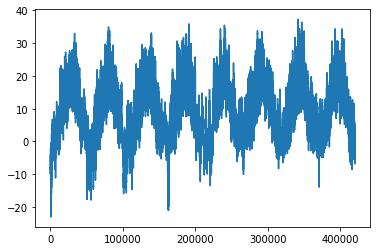

In [20]:
from matplotlib import pyplot as plt

temp = float_data[:, 1]  # Temeperature (in Celsius) we will get the following results:
plt.plot(range(len(temp)), temp)
plt.show()


Now let's look at the graph of temperature changes during the first ten days included in the harvest. The data was added to the set every 10 minutes. The daily graph of temperature changes consists of 144 points.

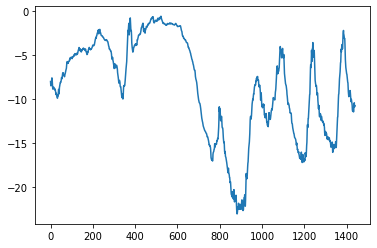

In [21]:
plt.plot(range(1440), temp[:1440])
plt.show()


In this graph you can see the daily cycle of temperature changes. It is particularly noticeable in the case of the last 4 days. Let's also pay attention to the fact that this 10-day period must come from a fairly cold winter month. 

Predicting the average temperature in the next month based on data from the previous few months is quite easy, because such data are repetitive on an annual basis, but looking at the data on a daily scale, you can get the impression that temperature changes are quite chaotic. Can the data of this time series be predicted on a daily scale? Let's check it out.

## Data preparation
Our problem is the following:

Based on data in the form of lookback observations made every 10 minutes, we select information on every step. Can we predict the temperature at the delay time interval on this basis? We will use the following parameter values: 
* 'lookback = 720' - we will use observations from 5 days;
 * 'steps = 6' - we will use one observation per hour; 
 * 'delay = 144' - our goal is to determine the temperature in 24 hours. To begin with, we need to do two things:

* Process the data to give it a form in which it can be routed to a neural network. It's simple. The data is already numerical, so there is no need to vectorize it. Unfortunately, each quantity is expressed on a different scale (temperature values usually range from –20 to +30, and atmospheric pressure is expressed in millibars and takes values oscillating around 1000. Each of the measured quantities should be standardised independently. Thanks to this, they will accept small values from similar ranges.

* Write a Python generator that accepts an array of floating-point values and returns data batches from the recent past (from a period specific to the point we want to predict). The samples in the collection are characterized by high redundancy (the N sample and the N+1 sample take assentially the same values). Therefore, it makes no sense to explicitly allocate each sample. Samples will be generated on an ongoing basis by using the original data.

We will prepare the data by calculating the average of each series and performing the operation of dividing by standard deviation. We will use the first 200,000 observations as a training dataset. Therefore, the mean and standard deviation should be calculated only on that part of the entire data set:

In [22]:
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std


Our data generator returns tuples (samples, targets) in which the samples object is the input and the targets object is an array of target temperatures.
The generator accepts the following arguments:

* 'data' — original floating-point data array
* 'lookback' — the number of time steps to which the input should reach;
* 'delay' — the number of time steps determining the future temperature; 
* 'min_index' and 'max_index' — indexes of the date array specifying the steps whose samples should be read. This solution is useful for creating a validation set and a test set;
* 'shuffle' — specifies whether samples are to be drawn or taken in chronological order;
* 'batch_size' — the number of samples included in the batch;
* 'step' — a time interval that determines the sampling rate of the data. We assign this parameter a value of 6 to have a sample of data read every hour.

In [23]:
def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets


Let's use the abstract generator function to create an instance of three generators: we need one generator for the training process, one for the validation process, and one for the testing process. Each of them will process different segments of the initial data set: the training generator processes the first 200,000 observations, the validation generator processes 100,000 consecutive observations, and the test generator processes the remaining observations.

In [24]:
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step, 
                      batch_size=batch_size)
val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step,
                    batch_size=batch_size)
test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

# Number of steps to retrieve data from the val_gen object
# ensuring the processing of the entire validation data set.
val_steps = (300000 - 200001 - lookback) // batch_size

# Number of steps to retrieve data from the test_gen object, 
# at which the entire test data set will be processed.
test_steps = (len(float_data) - 300001 - lookback) // batch_size

## Common sense reference point

Before we start predicting temperature with black boxes—deep learning models—let's try to do it with common sense. In this way, we will obtain a reference point for assessing the effectiveness of the machine learning model. Common sense is a good point of reference when working on new problems for which we do not (yet) have a solution. A classic example of such a situation is an uneven classification. If our dataset contains 90% of Class A observations and only 10% of Class B observations, then common sense would create a classifier that assigns the label A to all new observations. Such a classifier would have an efficiency of 90%, so all teaching techniques should have an efficiency greater than 90% in order to be considered useful. Sometimes the classifiers created in this way are really difficult to beat.

In the analyzed example, we can make a safe assumption about the continuity of temperatures (tomorrow's temperature will probably be close to today's temperature), as well as the existence of daily cycles of temperature fluctuations. Therefore, it would be common sense to predict that the temperature in 24 hours will always be equal to the current temperature. Let's validate this assumption using the average metric of the absolute error value:

In [10]:
# np.mean(np.abs(preds - targets))

Here's the evaluation loop:

In [25]:
def evaluate_naive_method():
    batch_maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    print(np.mean(batch_maes))
    
evaluate_naive_method()

0.2897359729905486


We will get a value equal to 0.29. The temperature values have been normalized to take a median value of 0 and a standard deviation of 1; the result obtained is not at all easy to interpret. The average absolute error value obtained by us corresponds to a temperature of 2.57°C (0.29 x temperature_std = 2.57). This is a fairly large average error value. Now we will try to take advantage of our knowledge of deep learning and get a better result.

## Basic solution to the problem by using a machine learning technique

As with the development of a simple logical method as a reference point, we can try to solve the problem using simple machine learning models (e.g. using small, densely connected networks). Let's do this before we get into more complicated models like recursive neural networks. This is the best way to make sure that using more complex models makes sense and brings real benefits.

Here's the code for a fully connected model that flattens the data first and then passes it through two Dense layers. The Dense layer does not use the activation function, which is typical for regression problems. As a loss function, we will again use the average absolute error. We carry out the evaluation using the same data and the same metric as in the case of the previously described solution acting as our reference point. We will be able to compare the results obtained in a direct way.

In [12]:
from keras.models import Sequential
from keras import layers
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, float_data.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  from ipykernel import kernelapp as app


500/500 [==============================] - 12s 19ms/step - loss: 1.4467 - val_loss: 0.7044
Epoch 2/20
500/500 [==============================] - 9s 19ms/step - loss: 0.4805 - val_loss: 0.3665
Epoch 3/20
500/500 [==============================] - 9s 19ms/step - loss: 0.3007 - val_loss: 0.3127
Epoch 4/20
500/500 [==============================] - 9s 19ms/step - loss: 0.2700 - val_loss: 0.2993
Epoch 5/20
500/500 [==============================] - 9s 19ms/step - loss: 0.2559 - val_loss: 0.3278
Epoch 6/20
500/500 [==============================] - 9s 19ms/step - loss: 0.2447 - val_loss: 0.2997
Epoch 7/20
500/500 [==============================] - 10s 19ms/step - loss: 0.2357 - val_loss: 0.3272
Epoch 8/20
500/500 [==============================] - 10s 20ms/step - loss: 0.2296 - val_loss: 0.3128
Epoch 9/20
500/500 [==============================] - 9s 19ms/step - loss: 0.2240 - val_loss: 0.3204
Epoch 10/20
500/500 [==============================] - 9s 19ms/step - loss: 0.2208 - val_loss: 0.32

Let's view the loss graphs in the training and validation processes:

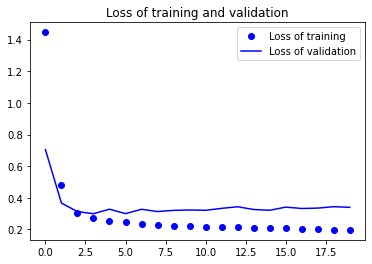

In [13]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Loss of training')
plt.plot(epochs, val_loss, 'b', label='Loss of validation')
plt.title('Loss of training and validation')
plt.legend()

plt.show()



Only some values of the validation loss are close to the result obtained by the reference method (the result obtained without machine learning). This example is intended to show that it is worth setting a reference point, and that crossing it using the model is not so easy. By developing a logical solution to the problem, unlike the model, we had access to valuable information.

Is there a simple model that can combine data with targets? Why can't the model we developed do this? This is because our simple solution does not seek an answer to this question. The space in which models seek a solution (hypothesis space) is the space of all possible two-layer networks with a configuration we defined. These networks are already quite complicated by themselves. If solutions are sought in a space consisting of complex models, simple, well-performing underlying solutions may be untrainable, despite the fact that, technically speaking, they belong to the space of hypotheses. This is an important limitation of machine learning: if the algorithm code is not written to look for a specific type of simple model, it may turn out that during training it is impossible to find a simple solution to a simple problem.

## Reference point in the form of the first recursive model

The first fully connected network didn't work well, but that doesn't mean machine learning can't solve the problem. This network first flattened the time series data, which removed the time information from the input. Let's try to look at the data without modifying it: analyze it as a sequence in which both randomness and order matter. We will try the recursive-sequential processing model. It should be perfect for processing sequential data. This is because, unlike the first model, it uses the order in which the observation data is set.

Instead of the LSTM layer, this time we will use the GRU layer developed in 2014 by a team led by Junyoung Chung. GRU layers (gate-constrained recursive units) work on the same principle as LSTM layers, but require less costly calculations. This in turn can generates inferior representations to LSTM layers. The trade-off between computational complexity and the power of representation is a standard machine learning problem.

In [14]:
from keras.models import Sequential
from keras import layers
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


500/500 [==============================] - 18s 28ms/step - loss: 0.3050 - val_loss: 0.2734
Epoch 2/20
500/500 [==============================] - 14s 27ms/step - loss: 0.2838 - val_loss: 0.2687
Epoch 3/20
500/500 [==============================] - 13s 27ms/step - loss: 0.2775 - val_loss: 0.2623
Epoch 4/20
500/500 [==============================] - 14s 27ms/step - loss: 0.2745 - val_loss: 0.2650
Epoch 5/20
500/500 [==============================] - 13s 27ms/step - loss: 0.2701 - val_loss: 0.2625
Epoch 6/20
500/500 [==============================] - 14s 28ms/step - loss: 0.2658 - val_loss: 0.2697
Epoch 7/20
500/500 [==============================] - 14s 27ms/step - loss: 0.2625 - val_loss: 0.2675
Epoch 8/20
500/500 [==============================] - 14s 27ms/step - loss: 0.2588 - val_loss: 0.2732
Epoch 9/20
500/500 [==============================] - 13s 27ms/step - loss: 0.2559 - val_loss: 0.2695
Epoch 10/20
500/500 [==============================] - 13s 27ms/step - loss: 0.2519 - val_los

Time to show the results in a graph:

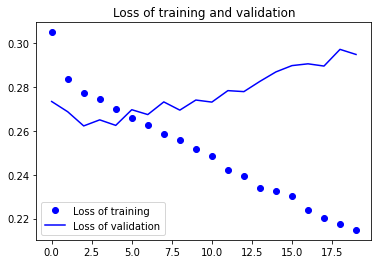

In [15]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Loss of training')
plt.plot(epochs, val_loss, 'b', label='Loss of validation')
plt.title('Loss of training and validation')
plt.legend()

plt.show()


Now we have obtained much better parameters! We have significantly defeated the predefined logical classifier that is our reference point. We have proven the wisdom of using machine learning, as well as the superiority of recursive networks over dense sequence flattening networks in this type of tasks. We obtained an average absolute error value of ~0.265 (before the model began to undergo significant overhaul), which corresponds to an average error of 2.35 ° C. This is a clear improvement over the previously obtained value of 2.57 ° C, but we can still get a much better result.

In [16]:
from keras.models import Sequential
from keras import layers
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32,
                     dropout=0.2,
                     recurrent_dropout=0.2,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


500/500 [==============================] - 386s 768ms/step - loss: 0.3218 - val_loss: 0.2944
Epoch 2/20
500/500 [==============================] - 382s 765ms/step - loss: 0.3049 - val_loss: 0.2718
Epoch 3/20
500/500 [==============================] - 381s 762ms/step - loss: 0.3001 - val_loss: 0.2744
Epoch 4/20
500/500 [==============================] - 382s 764ms/step - loss: 0.2943 - val_loss: 0.2728
Epoch 5/20
500/500 [==============================] - 382s 764ms/step - loss: 0.2890 - val_loss: 0.2731
Epoch 6/20
500/500 [==============================] - 384s 769ms/step - loss: 0.2862 - val_loss: 0.2771
Epoch 7/20
500/500 [==============================] - 384s 768ms/step - loss: 0.2782 - val_loss: 0.2735
Epoch 8/20
500/500 [==============================] - 385s 770ms/step - loss: 0.2755 - val_loss: 0.2792
Epoch 9/20
500/500 [==============================] - 383s 765ms/step - loss: 0.2716 - val_loss: 0.2771
Epoch 10/20
500/500 [==============================] - 383s 766ms/step - lo

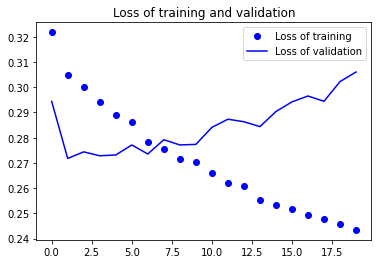

In [17]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Loss of training')
plt.plot(epochs, val_loss, 'b', label='Loss of validation')
plt.title('Loss of training and validation')
plt.legend()

plt.show()

Very well! During the first 30 epochs of the algorithm's work, there is no excessive matching. Despite the fact that the evaluation results are more stable, the best results obtained by us are much lower than those we obtained earlier.

## Create recursive layer stacks

The model does not over-fit, but we have come to a performance bottleneck and we should think about increasing the capacity of the network. Recall the description of a universal machine learning workflow: In general, it's a good idea to increase network capacity until over-matching becomes a major obstacle (assuming you're doing basic steps to prevent overfitting, such as discarding). If we don't achieve an over-match, we can most likely get a better model.)

Network capacity is typically enlarged by increasing the number of units in layers or by adding more layers. Creating recursive layer stacks is a classic way to build stronger recursive networks: currently, the Google Translate algorithm is based on a stack of seven LSTM layers (it's a huge network). To create a stack of recursive layers in Keras, ensure that all intermediate layers return full output sequences (three-dimensional tensors), not just the output objects generated during the processing of the last observation. To do this, assign a value of True to the return_sequence parameter:

In [10]:
from keras.models import Sequential
from keras import layers
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32,
                     dropout=0.1,
                     recurrent_dropout=0.5,
                     return_sequences=True,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.GRU(64, activation='relu',
                     dropout=0.1, 
                     recurrent_dropout=0.5))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


500/500 [==============================] - 425s 840ms/step - loss: 0.3213 - val_loss: 0.2791
Epoch 2/20
500/500 [==============================] - 418s 836ms/step - loss: 0.3008 - val_loss: 0.2811
Epoch 3/20
500/500 [==============================] - 418s 837ms/step - loss: 0.2929 - val_loss: 0.2778
Epoch 4/20
500/500 [==============================] - 422s 844ms/step - loss: 0.2871 - val_loss: 0.2742
Epoch 5/20
500/500 [==============================] - 422s 843ms/step - loss: 0.2788 - val_loss: 0.2690
Epoch 6/20
500/500 [==============================] - 417s 835ms/step - loss: 0.2726 - val_loss: 0.2836
Epoch 7/20
500/500 [==============================] - 421s 842ms/step - loss: 0.2685 - val_loss: 0.2774
Epoch 8/20
500/500 [==============================] - 422s 844ms/step - loss: 0.2634 - val_loss: 0.2941
Epoch 9/20
500/500 [==============================] - 426s 852ms/step - loss: 0.2590 - val_loss: 0.2831
Epoch 10/20
500/500 [==============================] - 417s 833ms/step - lo

Time to show the results on a plot:

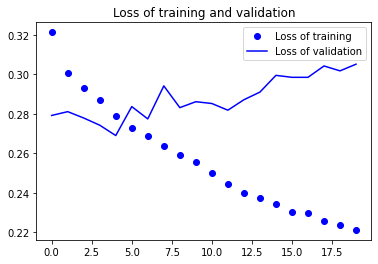

In [13]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Loss of training')
plt.plot(epochs, val_loss, 'b', label='Loss of validation')
plt.title('Loss of training and validation')
plt.legend()

plt.show()

The chart shows that adding a layer improves the work of the model slightly, but this is not a significant improvement.
Two conclusions can be drawn from this:
* There is no over-fitting, so it is safe to increase the layer size to improve validation loss.
Of course, this is associated with an increased computational cost.
* Adding a layer did not result in a significant improvement, so further increasing the capacity of the network may lead to an increasingly noticeable improvement in the performance of the model.

## Using bidirectional recursive neural networks

The last solution that we would like to introduce is the bidirectional recursive neural network. These are popular versions of recursive networks, which for some tasks are characterized by very good performance. They are often used in natural language processing. It can be described as a universal lockpick that works well when working on problems related to natural language processing.

Recursive neural networks process dependencies resulting from the sequence or passage of time — they process sequences in an orderly manner. Changing the order of observations or reversing it can completely change the representations created by this type of network. It is for this reason that these networks work well when solving problems in which the order matters (an example of such a problem is temperature forecasting). Bidirectional recursive neural networks use this property of recursive networks. They consist of two standard recursive networks (e.g. GRU or LSTM layers). Each of these component networks processes the input sequence in a different direction (chronological or opposite to chronological). The representations they create are then combined. A bidirectional recursive network, by processing the sequence in both directions, can catch dependencies that are not perceived by the one-way recursive network.

Of course, the chronological processing of sequences by the layers of recursive networks presented so far is our unconscious choice (so far we have not had the opportunity to question its reasonableness). Would recursive networks work well enough if they processed input sequences in the opposite direction to chronological order? Let's check it in practice, Just create a generator that reverses the input sequence according to the dimension that is the timeline (we need to replace the last line of code with the following solution: yield samples[:, ::-1, :], targets). After training the same network with one GRU layer (we used this layer in the first experiment), we will get the following results:

In [14]:
def reverse_order_generator(data, lookback, delay, min_index, max_index,
                            shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples[:, ::-1, :], targets
        
train_gen_reverse = reverse_order_generator(
    float_data,
    lookback=lookback,
    delay=delay,
    min_index=0,
    max_index=200000,
    shuffle=True,
    step=step, 
    batch_size=batch_size)
val_gen_reverse = reverse_order_generator(
    float_data,
    lookback=lookback,
    delay=delay,
    min_index=200001,
    max_index=300000,
    step=step,
    batch_size=batch_size)

In [15]:
model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen_reverse,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen_reverse,
                              validation_steps=val_steps)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  # Remove the CWD from sys.path while we load stuff.


500/500 [==============================] - 92s 181ms/step - loss: 0.4818 - val_loss: 0.4726
Epoch 2/20
500/500 [==============================] - 96s 191ms/step - loss: 0.4418 - val_loss: 0.4582
Epoch 3/20
500/500 [==============================] - 95s 190ms/step - loss: 0.3706 - val_loss: 0.3819
Epoch 4/20
500/500 [==============================] - 93s 187ms/step - loss: 0.3191 - val_loss: 0.3550
Epoch 5/20
500/500 [==============================] - 92s 185ms/step - loss: 0.2923 - val_loss: 0.3472
Epoch 6/20
500/500 [==============================] - 91s 183ms/step - loss: 0.2794 - val_loss: 0.3333
Epoch 7/20
500/500 [==============================] - 91s 182ms/step - loss: 0.2706 - val_loss: 0.3377
Epoch 8/20
500/500 [==============================] - 91s 181ms/step - loss: 0.2629 - val_loss: 0.3344
Epoch 9/20
500/500 [==============================] - 91s 182ms/step - loss: 0.2561 - val_loss: 0.3420
Epoch 10/20
500/500 [==============================] - 92s 185ms/step - loss: 0.2504

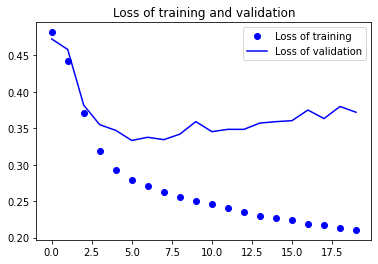

In [16]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Loss of training')
plt.plot(epochs, val_loss, 'b', label='Loss of validation')
plt.title('Loss of training and validation')
plt.legend()

plt.show()

In [26]:
from keras.datasets import imdb
from keras.preprocessing import sequence
from keras import layers
from keras.models import Sequential

# The number of words treated as characteristics.
max_features = 10000
# Cuts reviews after this number of words belonging to the set of max_features words most common in the set.
maxlen = 500

# Loading data.
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

# Reverse sequence.
x_train = [x[::-1] for x in x_train]
x_test = [x[::-1] for x in x_test]

# Sequence blocking.
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)

model = Sequential()
model.add(layers.Embedding(max_features, 128))
model.add(layers.LSTM(32))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

17473536/17464789 [==============================] - 0s 0us/step
Epoch 1/10
157/157 [==============================] - 80s 496ms/step - loss: 0.4850 - acc: 0.7665 - val_loss: 0.3964 - val_acc: 0.8332
Epoch 2/10
157/157 [==============================] - 76s 481ms/step - loss: 0.3055 - acc: 0.8818 - val_loss: 0.4162 - val_acc: 0.8246
Epoch 3/10
157/157 [==============================] - 76s 482ms/step - loss: 0.2523 - acc: 0.9071 - val_loss: 0.3336 - val_acc: 0.8736
Epoch 4/10
157/157 [==============================] - 75s 480ms/step - loss: 0.2127 - acc: 0.9226 - val_loss: 0.3733 - val_acc: 0.8462
Epoch 5/10
157/157 [==============================] - 76s 483ms/step - loss: 0.1855 - acc: 0.9344 - val_loss: 0.3341 - val_acc: 0.8718
Epoch 6/10
157/157 [==============================] - 82s 521ms/step - loss: 0.1664 - acc: 0.9409 - val_loss: 0.4101 - val_acc: 0.8750
Epoch 7/10
157/157 [==============================] - 75s 477ms/step - loss: 0.1513 - acc: 0.9484 - val_loss: 0.6295 - val_ac

To create a bidirectional recursive network instance, use the Bidirectional layer implemented in Keras. it takes the recursive layer instance as its first argument. The Bidirectional function creates a second separate instance of this layer. One instance is used to process the input sequence in a chronological direction, and the other instance is used to process the reversed input sequence. Let's try this solution to solve the problem of sentiment analysis of reviews of films included in the IMDB collection.

In [27]:
from keras import backend as K
K.clear_session()

In [28]:
model = Sequential()
model.add(layers.Embedding(max_features, 32))
model.add(layers.Bidirectional(layers.LSTM(32)))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(x_train, y_train, epochs=10, batch_size=128, validation_split=0.2)

Epoch 1/10
157/157 [==============================] - 104s 635ms/step - loss: 0.5513 - acc: 0.7264 - val_loss: 0.4612 - val_acc: 0.8104
Epoch 2/10
157/157 [==============================] - 99s 632ms/step - loss: 0.3286 - acc: 0.8746 - val_loss: 0.3891 - val_acc: 0.8536
Epoch 3/10
157/157 [==============================] - 99s 631ms/step - loss: 0.2632 - acc: 0.9025 - val_loss: 0.3484 - val_acc: 0.8494
Epoch 4/10
157/157 [==============================] - 99s 633ms/step - loss: 0.2257 - acc: 0.9189 - val_loss: 0.3344 - val_acc: 0.8862
Epoch 5/10
157/157 [==============================] - 100s 634ms/step - loss: 0.2031 - acc: 0.9311 - val_loss: 0.3666 - val_acc: 0.8630
Epoch 6/10
157/157 [==============================] - 99s 630ms/step - loss: 0.1823 - acc: 0.9365 - val_loss: 0.3184 - val_acc: 0.8708
Epoch 7/10
157/157 [==============================] - 99s 630ms/step - loss: 0.1645 - acc: 0.9422 - val_loss: 0.3663 - val_acc: 0.8808
Epoch 8/10
157/157 [==============================] -

This solution performs slightly better than the previously presented code using the standard LSTM layer – now we have a validation accuracy of over 87%. This model begins to be learned more quickly, which is not surprising – a two-way layer has twice as many parameters as a regular LSTM layer. With the addition of mechanisms to ensure regularization, the two-way data processing technique would work even better in this task. Let's check the operation of this method when predicting temperature:

In [30]:
from keras.models import Sequential
from keras import layers
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Bidirectional(
    layers.GRU(32), input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  from ipykernel import kernelapp as app


500/500 [==============================] - 158s 308ms/step - loss: 0.2981 - val_loss: 0.2795
Epoch 2/20
500/500 [==============================] - 154s 307ms/step - loss: 0.2732 - val_loss: 0.2670
Epoch 3/20
500/500 [==============================] - 154s 308ms/step - loss: 0.2668 - val_loss: 0.2708
Epoch 4/20
500/500 [==============================] - 154s 308ms/step - loss: 0.2637 - val_loss: 0.2668
Epoch 5/20
500/500 [==============================] - 156s 313ms/step - loss: 0.2578 - val_loss: 0.2759
Epoch 6/20
500/500 [==============================] - 157s 315ms/step - loss: 0.2503 - val_loss: 0.2698
Epoch 7/20
500/500 [==============================] - 155s 310ms/step - loss: 0.2445 - val_loss: 0.2714
Epoch 8/20
500/500 [==============================] - 153s 307ms/step - loss: 0.2364 - val_loss: 0.2754
Epoch 9/20
500/500 [==============================] - 154s 308ms/step - loss: 0.2289 - val_loss: 0.2864
Epoch 10/20
500/500 [==============================] - 154s 308ms/step - lo

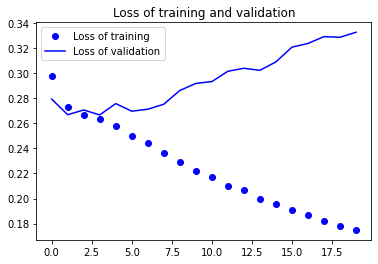

In [31]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Loss of training')
plt.plot(epochs, val_loss, 'b', label='Loss of validation')
plt.title('Loss of training and validation')
plt.legend()

plt.show()